# Experimental Starter

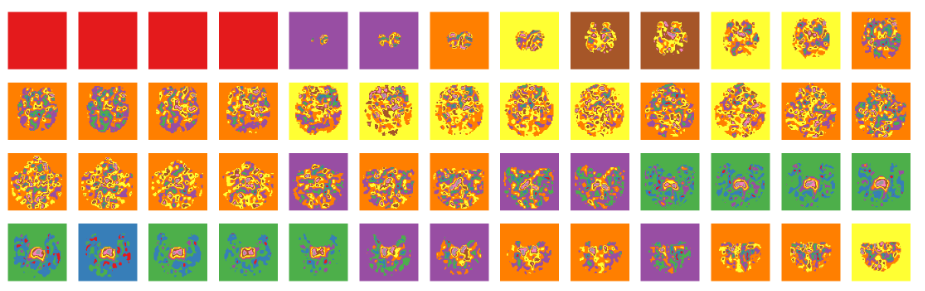

This is a first draft experimental `fastai2` starter notebook.  This dataset is really interesting because it has images that are in 3 different orientations and the output has to be a prediction of 5 features `[age, domain1_var1, domain1_var2, domain2_var1, domain2_var2]` where each feature has the following weights `[.3, .175, .175, .175, .175]` 

In [ ]:
!pip install fastai2 --quiet

# Exploring the images

In [ ]:
#Load the dependancies
from fastai2.vision.all import *

import numpy as np
import pandas as pd
import os
import h5py
import nilearn as nl
from nilearn import image, datasets, plotting
from nilearn.image import get_data
from random import randint

matplotlib.rcParams['image.cmap'] = 'gray'

In [ ]:
source = Path("../input/trends-assessment-prediction")
files = os.listdir(source)
print(files)

In [ ]:
fnc = pd.read_csv(f'{source}/train_scores.csv')
fnc.head()

The images are stored in `.mat` (MATLAB) format in 2 folders `fMRI_train` and `fMRI_test`

We can access the files using the `get_files` function from `fastai2`.

#### Train Files

In [ ]:
train_files = get_files(source/'fMRI_train')
train_files

#### Test Files

In [ ]:
test_files = get_files(source/'fMRI_test')
test_files

Both the `train` and `test` folders contain 5877 files each.  We cannot access the files using standard `fastai2` methods and need to be accessed using `h5py.File`.  You have to specify a mode when using `h5py.File` in this case we use `r` for reading the file.  In this dataset the `.mat` files are pretty similar to working with `dicom` files where there is a `head` and the `array of pixels`

In [ ]:
test_img = train_files[0]
test_img = h5py.File(test_img, 'r')
test_img

The data inside the file can be accessed by accessing the `keys()` within the file.

In [ ]:
test_img.keys()

In this case the data is stored within the `SM_feature` key

In [ ]:
test_img['SM_feature']

Each `.mat` file is a 4D tensor with the shape of (53, 52, 63, 53)

![](http://www.talairach.org/images/brain.gif)

Each file contains 52 images orientated in the `x-axis`, 63 images in the `y-axis` and 53 images in the `z-axis`.

In [ ]:
test_image = train_files[0]
t = h5py.File(test_image, 'r')['SM_feature'][()]

Lets take a look at image `19` from the `x-axis` and the `28th` slice

In [ ]:
x_axis = t[:,:,19].transpose(1,2,0)
plt.imshow(x_axis[:, :,28])

`show_images` does not allow you to specify colormaps and the default in `fastai2` is set at `viridis`.  We can update the `show_images` function by using `@delegates` to include a `cmap` option

In [ ]:
@delegates(subplots)
def show_images(ims, nrows=1, ncols=None, titles=None, cmap=None, **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    if ncols is None: ncols = int(math.ceil(len(ims)/nrows))
    if titles is None: titles = [None]*len(ims)
    axs = subplots(nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip(ims, titles, axs): show_image(im, ax=ax, title=t, cmap=cmap)

Still with the `test_image` lets view all the images within this 1 `.mat` file.

Starting with images within the `x-axis` (there are 53), note the choosen `cmap` color is just for adding color to the notebook :)

In [ ]:
x_list = []
for i in range(52):
    x_axis = t[:,:,i].transpose(1,2,0)
    x_ = x_axis[:, :,0]
    x_list.append(x_)

In [ ]:
show_images(x_list, nrows=4, cmap=plt.cm.Set1)

Now the `y_axis`

In [ ]:
y_list = []
for i in range(63):
    y_axis = t[:, :, i, :].transpose(1, 2, 0)
    y_ = y_axis[:, :,0]
    y_list.append(y_)

In [ ]:
show_images(y_list, nrows=4, cmap=plt.cm.Set1)

what about the `z_axis`?

In [ ]:
z_list = []
for i in range(52):
    z_axis = t[:, i, :, :].transpose(1, 2, 0)
    z_ = z_axis[:, :,0]
    z_list.append(z_)

In [ ]:
show_images(z_list, nrows=4, cmap=plt.cm.Set1)

# Building the DataBlock

In [ ]:
train_path = source/'fMRI_train'
train_path

As there are images in the `x`, `y` and `z` axis we need to specify how we get those images into the `DataBlock`

Specify a function to get images from the `x` orientation

In [ ]:
def mat_x(fn):
    file = int(fn.Id)
    im = f'{train_path}/{file}.mat'
    t = h5py.File(im, 'r')['SM_feature'][()]
    idx_3 = randint(0, 52)
    x_axis = t[:, :, :, idx_3].transpose(1, 2, 0)
    return x_axis[:, :, 0]

`y` orientation

In [ ]:
def mat_y(fn):
    file = int(fn.Id)
    im = f'{train_path}/{file}.mat'
    t = h5py.File(im, 'r')['SM_feature'][()]
    idx_2 = randint(0, 62)
    y_axis = t[:, :, idx_2, :].transpose(1, 2, 0)
    return y_axis[:, :, 0]

`z` orientation

In [ ]:
def mat_z(fn):
    file = int(fn.Id)
    im = f'{train_path}/{file}.mat'
    t = h5py.File(im, 'r')['SM_feature'][()]
    idx_1 = randint(0, 51)
    z_axis = t[:, idx_1, :, :].transpose(1, 2, 0)
    return z_axis[:, :, 0]

Now we need to specify the outputs, in this case we have to predict 5 features `[age, domain1_var1, domain1_var2, domain2_var1, domain2_var2]`.

In [ ]:
age_ = fnc['age'].unique()
dom1_ = fnc['domain1_var1'].unique()
dom2_ = fnc['domain1_var2'].unique()
dom3_ = fnc['domain2_var1'].unique()
dom4_ = fnc['domain2_var2'].unique()

Specify the `blocks` thats the beauty about `fastai2` we can easily specify what the `blocks` will be.  In this case we have 3 `ImageBlock`'s because we have images from the `x`, `y` and `z` axis and we will need 5 `CategoryBlock`'s because we have to predict 5 features.

In [ ]:
blocks = (
          ImageBlock(cls=PILImage),
          ImageBlock(cls=PILImage),
          ImageBlock(cls=PILImage),
          CategoryBlock(vocab=age_),
          CategoryBlock(vocab=dom1_),
          CategoryBlock(vocab=dom2_),
          CategoryBlock(vocab=dom3_),
          CategoryBlock(vocab=dom4_)
          )
         
getters = [
           mat_x,
           mat_y,
           mat_z,
           ColReader('age'),
           ColReader('domain1_var1'),
           ColReader('domain1_var2'),
           ColReader('domain2_var1'),
           ColReader('domain2_var2')
          ]

trends = DataBlock(blocks=blocks,
              getters=getters,
              item_tfms=Resize(128),
              n_inp=3
              )

`fastai2` provides a handy function `summary` that you can use to check to see if there are any issues when building the `pipeline`

In [ ]:
trends.summary(fnc)

In [ ]:
dls = trends.dataloaders(fnc, bs=4)

In [ ]:
dls.show_batch(max_n=4)

## Next Steps

- Clean the data
- Create a `Learner` for training
- Experiment